This notebook is about reshaping a bit Alex's work (5_mnist_autoencoder notebook) to use the 1d-maxpooling after reindexing and also to use Chebishev coefficients for the filtering. 

In [1]:
%cd ..

/home/clement/Dropbox/MVA/Graphs in ML/project/graphConvNet


In [2]:
# Imports
import sys, os
sys.path.insert(0,os.getcwd())  # add current folder to sources
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt

from src.mnist import load_mnist  # helper to load MNIST data
from src.GraphMaxPooling import GraphMaxPooling
from src.GraphLayers import *

numpy.set_printoptions(threshold=numpy.nan)
from IPython.display import clear_output
%matplotlib inline

# Data, coarsening, laplacians

In [3]:
# Load mnist dataset
training_mnist = load_mnist(dataset='training')
testing_mnist = load_mnist(dataset='testing')

training_data = numpy.reshape(training_mnist[0], [training_mnist[0].shape[0],28*28])
training_data = training_data/255.0
training_labels = training_mnist[1]
training_cats = numpy.zeros([training_labels.shape[0], 10])
for i in range(0,training_labels.shape[0]):
    training_cats[i][training_labels[i]]=1
    
testing_data = numpy.reshape(testing_mnist[0], [testing_mnist[0].shape[0],28*28])
testing_data = testing_data/255.0
testing_labels = testing_mnist[1]
testing_cats = numpy.zeros([testing_labels.shape[0], 10])
for i in range(0,testing_labels.shape[0]):
    testing_cats[i][testing_labels[i]]=1

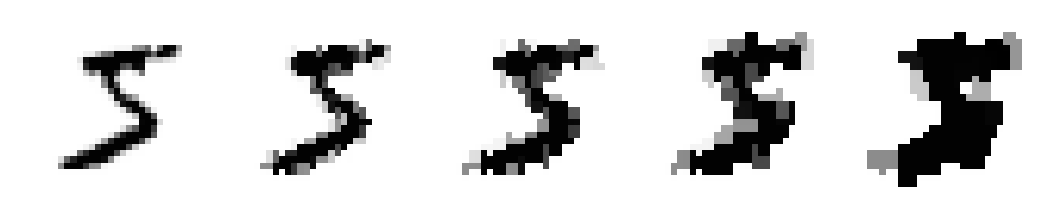

In [4]:
# use the GraphMaxPooling class to build a grid and perform the coarsening
W = GraphMaxPooling.generate_grid(*training_mnist[0][0].shape)
foo_pooling = GraphMaxPooling(W, 4)
foo_pooling.plot_pooled_images(training_mnist[0][0].reshape((-1,)))  # plot what happens

In [5]:
# now we retrieve all the new ordering and we add the virtuals nodes and reshape the signal
# to clean matrices X_train and X_test

ordering = foo_pooling.new_order
init_dim = 28*28  # initial dimension of the images
n_virtuals = len(ordering) - init_dim  # number of virtual nodes to add

# First for X_train
X_train = training_mnist[0].reshape((-1, init_dim))  # flatten images
X_train = np.hstack((X_train, np.zeros((X_train.shape[0], n_virtuals))))  # add zeros for virtuals
X_train = X_train[:, ordering]  # reorder

# Then for X_test
X_test = testing_mnist[0].reshape((-1, init_dim))  # flatten images
X_test = np.hstack((X_test, np.zeros((X_test.shape[0], n_virtuals))))  # add zeros for virtuals
X_test = X_test[:, ordering]  # reorder

In [6]:
print("X_train: {}, including {} true nodes and {} virtual nodes".format(X_train.shape, init_dim, n_virtuals))
print("X_test:  {}, including {} true nodes and {} virtual nodes".format(X_test.shape, init_dim, n_virtuals))

X_train: (60000, 1088), including 784 true nodes and 304 virtual nodes
X_test:  (10000, 1088), including 784 true nodes and 304 virtual nodes


In [7]:
# Now we retrieve all the Laplacians
laplacians = foo_pooling.get_laplacians(how='unn')
laplacians = [np.array(L, dtype=np.float32) for L in laplacians]  # cast to float32
print([L.shape for L in laplacians])

[(1088, 1088), (544, 544), (272, 272), (136, 136), (68, 68)]


And that's all we need. Now we will (in the next section) build our network, as if we were dealing with 1d signals (for the max-pooling part). The only tricky part is to implement the filters using Chebyshev. 

# Building the network

To build our CNN we use the objects from the GraphLayers module. The GraphConv objects take as input a symbolic tensor which must be the output attribute from the previous layer.

In [17]:
# We instantiate Session object
tf.reset_default_graph()
sess = tf.InteractiveSession()

**Encoder part**

In [18]:
X_input = tf.placeholder(tf.float32, [None, laplacians[0].shape[0]])  # X_train or X_test
X_input_ = tf.expand_dims(X_input, 2)  # add depth dimension

GConv1 = GraphConv(X_input_, K=5, F=1, L=laplacians[0])
GConv1.max_pool()

GConv2 = GraphConv(GConv1.output, K=5, F=1, L=laplacians[1])
GConv2.max_pool()

GConv3 = GraphConv(GConv2.output, K=5, F=1, L=laplacians[2])
GConv3.max_pool()

GConv4 = GraphConv(GConv3.output, K=5, F=1, L=laplacians[3])
GConv4.max_pool()

** Decoder part **

In [19]:
GConv4_bis = GraphConv(GConv4.output, K=None, F=None, L = None)  # no filtering, just unpooling
GConv4_bis.un_pool()

GConv5 = GraphConv(GConv4_bis.output, K=5, F=1, L=laplacians[3])
GConv5.un_pool()

GConv6 = GraphConv(GConv5.output, K=5, F=1, L=laplacians[2])
GConv6.un_pool()

GConv7 = GraphConv(GConv6.output, K=5, F=1, L=laplacians[1])
GConv7.un_pool()

GConv8 = GraphConv(GConv7.output, K=5, F=1, L=laplacians[0])

y_output = GConv8.output

# Training phase

Train phase (copied from 4_mnist_classifier.ipynb)

In [20]:
layers = [GConv1, GConv2, GConv3, GConv4, GConv4_bis, GConv5, GConv6, GConv7, GConv8]
weights = [l.theta for l in layers if l.theta is not None]

In [21]:
# Define Loss
distance = tf.nn.l2_loss(tf.subtract(y_output,X_input_))
weights_decay = tf.add_n([tf.nn.l2_loss(v) for v in weights])*0.001
loss = tf.add(distance, weights_decay)
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [22]:
# We initialize the values
sess.run(tf.global_variables_initializer())

step 4900, training loss 5.70984e+07, testing loss 6.16111e+07


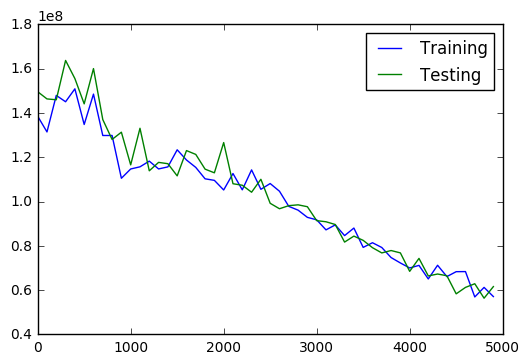

In [23]:
hist = numpy.ones([300,3])*numpy.nan
# Train
for i in range(5000):
    idx = numpy.random.permutation(X_train.shape[0])
    idx = idx[0:50]
    if i%100 == 0:
        train_loss = distance.eval(feed_dict={X_input:X_train[idx]})
        idx = numpy.random.permutation(X_test.shape[0])
        idx = idx[0:50]
        test_loss = distance.eval(feed_dict={X_input:X_test[idx]})
        hist[i/100][0] = i
        hist[i/100][1] = train_loss
        hist[i/100][2] = test_loss
        clear_output()
        print("step %d, training loss %g, testing loss %g"%(i, train_loss, test_loss))
        plt.plot(hist[:,0],hist[:,1], label="Training")
        plt.plot(hist[:,0],hist[:,2], label="Testing")
        plt.legend()
        plt.savefig("autoencoder_loss_curve.pdf")
        plt.show()
    train_step.run(feed_dict={X_input: X_train[idx]})

In [26]:
# we need to reorder final outputs (and also to remove virtual nodes)
ordering_inverse = np.array([int(np.where(ordering == i)[0]) for i in range(28*28)])

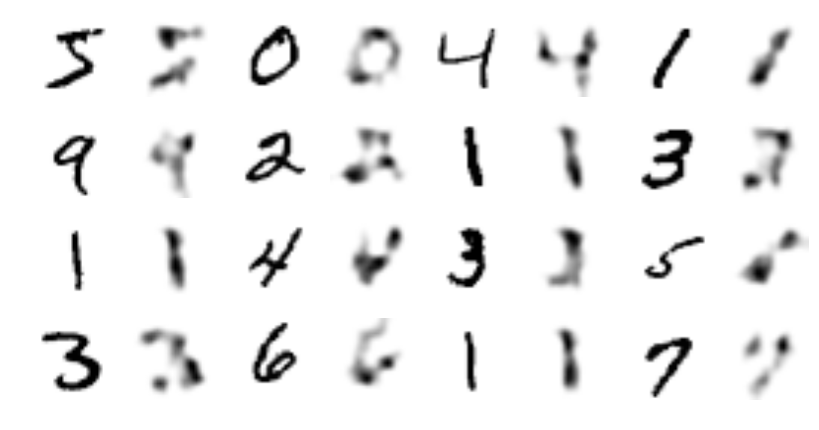

In [27]:
# Check if things are working expectedly
nb = 4
sample = X_train[0:nb*nb]
out= y_output.eval(feed_dict={X_input: sample}).reshape((nb*nb, -1))
out = out[:, ordering_inverse].reshape((-1, 28, 28))
fig = plt.figure(figsize=(10,5))

for i in range(sample.shape[0]):
    ax = fig.add_subplot(nb, 2*nb, 2*i+1)
    ax.axis('off')
    ax.imshow(numpy.reshape(sample[i, ordering_inverse], [28,28]), cmap="Greys")
    ax = fig.add_subplot(nb, 2*nb, 2*i+2)
    ax.axis('off')
    plt.imshow(numpy.reshape(out[i], [28,28]), cmap="Greys")
# plt.savefig("reconstruction.pdf")
plt.show()

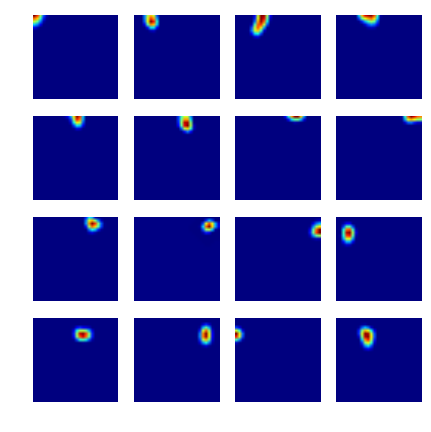

In [37]:
nb = 4
fig = plt.figure(figsize=(5,5))

_, coding_size, _ = GConv4.output.get_shape()
coding_size = int(coding_size)

for i in range(nb*nb):
    ax = fig.add_subplot(nb, nb, i+1)
    ax.axis('off')
    a = numpy.zeros([1,coding_size,1])
    a[0,i,0] = 1
    b = y_output.eval(feed_dict={GConv4.output:a})
    plt.imshow(numpy.reshape(b[:,ordering_inverse,:] ,[28,28]))
# plt.savefig('code.pdf')
plt.show()